In [1]:
import sys

from IPython.display import display
from torchvision import transforms
from torch.utils.data import DataLoader
from accelerate import Accelerator
from torch.optim import AdamW
from transformers import get_scheduler

sys.path.append("../")
from src import (
    Params,
    create_hf_train_dataset,
    FFHQDataset,
    tensor2PIL,
    CombinedFilter,
    BufferedDataLoader,
    MSRResNet,
    RealESRNetWrapper
)

In [2]:
config_path = "./config.json"
train_data_dir = "../data/train"

In [3]:
config = Params(config_path)
blur_config = config.DATA.BLUR
filter_config = config.DATA.FILTER

In [4]:
accelerator = Accelerator(
    mixed_precision=config.ACCELERATOR.MIXED_PRECISION,
    gradient_accumulation_steps=config.ACCELERATOR.GRADIENT_ACCUMULATION_STEPS,
)

# Look at Prepared Data

In [5]:
hf_train_dataset = create_hf_train_dataset(train_data_dir)

train_transform = transforms.Compose(
    [
        transforms.Resize(config.DATA.DATA_AUGMENTATION.RESIZE_RESOLUTION),
        (
            transforms.RandomCrop(config.DATA.DATA_AUGMENTATION.TARGET_RESOLUTION)
            if config.DATA.DATA_AUGMENTATION.RANDOM_CROP
            else transforms.CenterCrop(config.DATA.DATA_AUGMENTATION.TARGET_RESOLUTION)
        ),
        (
            transforms.RandomHorizontalFlip()
            if config.DATA.DATA_AUGMENTATION.RANDOM_HORIZONTAL_FLIP
            else transforms.Lambda(lambda x: x)
        ),
        transforms.ToTensor(),
    ]
)
train_dataset = FFHQDataset(hf_train_dataset, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=config.TRAINING.BATCH_SIZE.TRAIN, shuffle=True)

combined_filter = CombinedFilter(
    blur_config,
    filter_config,
    config.MODEL.SCALE,
    config.DATA.DATA_AUGMENTATION.TARGET_RESOLUTION,
    accelerator.device,
)
buffered_dataloader = BufferedDataLoader(
    train_dataloader, config.TRAINING.BUFFER_TIMES, combined_filter, accelerator
)

In [6]:
lq_batch, gt_batch, gt_usm_batch = next(iter(buffered_dataloader))

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 1
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


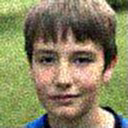

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


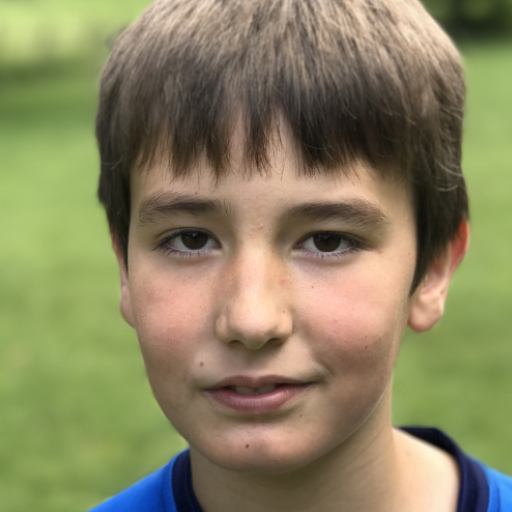

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


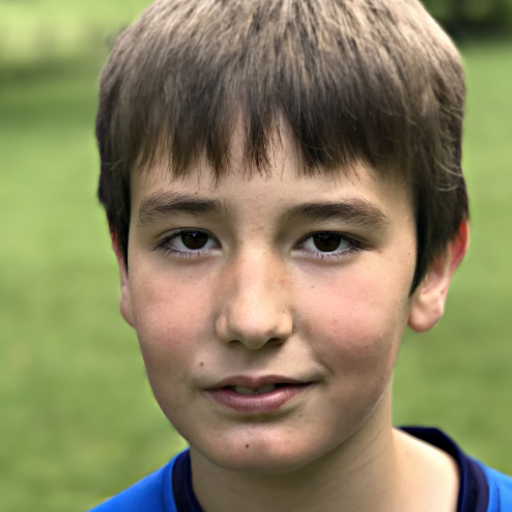

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 2
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


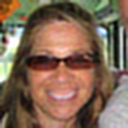

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


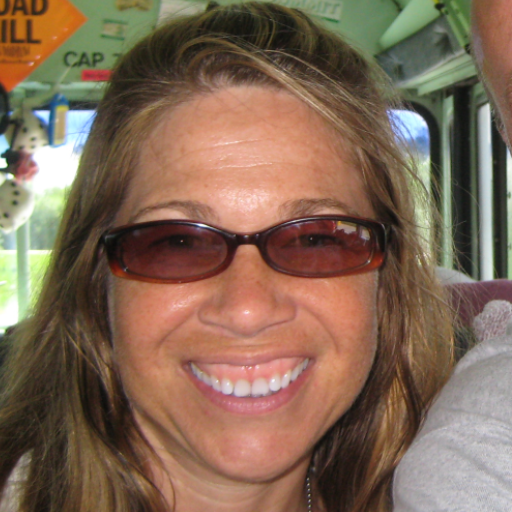

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


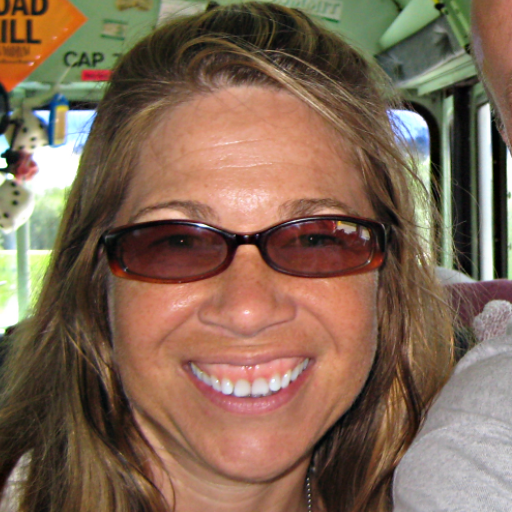

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 3
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


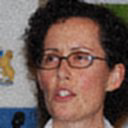

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


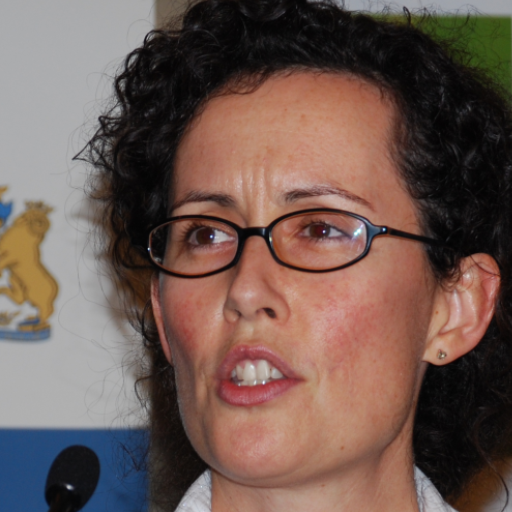

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


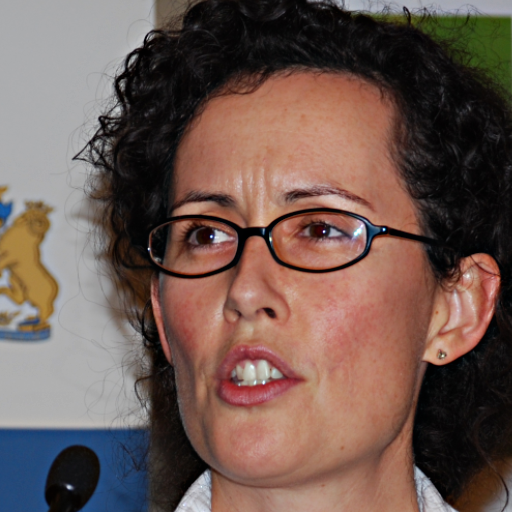

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 4
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


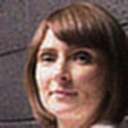

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


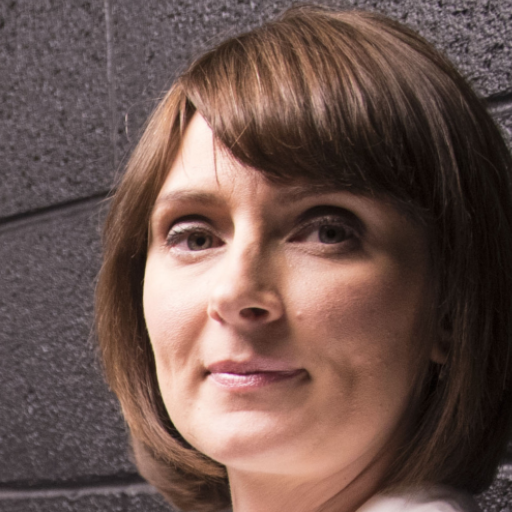

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


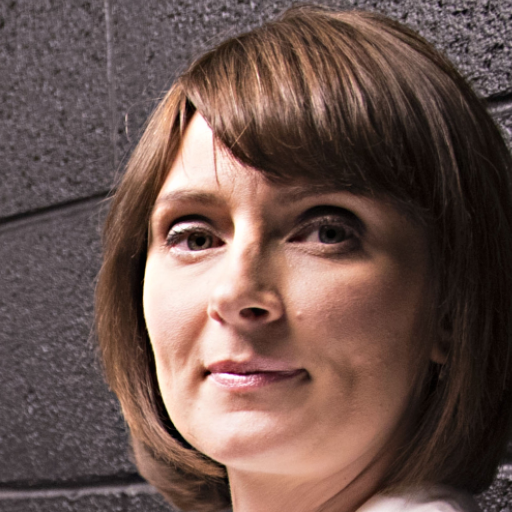

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 5
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


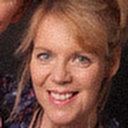

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


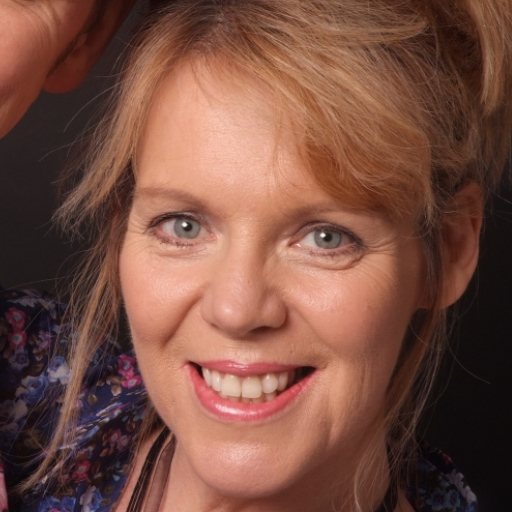

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


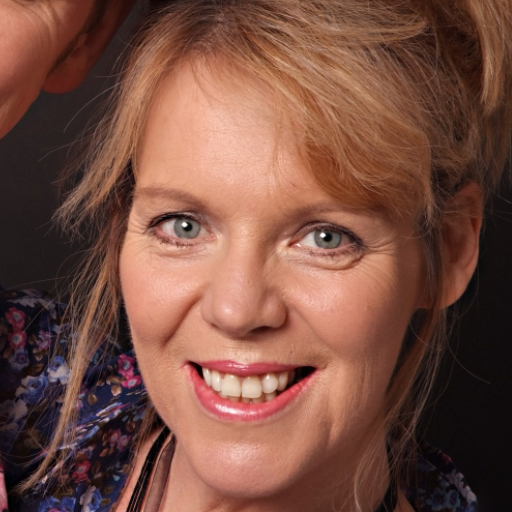

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 6
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


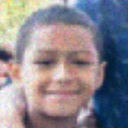

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


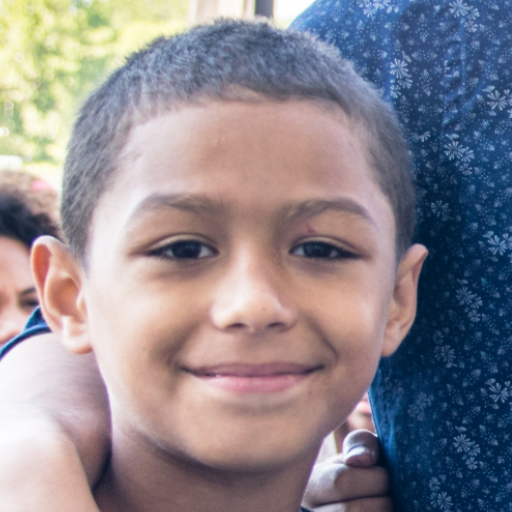

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


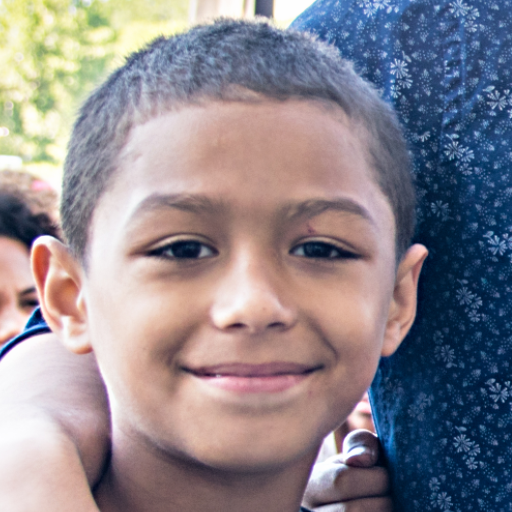

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 7
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


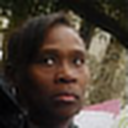

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


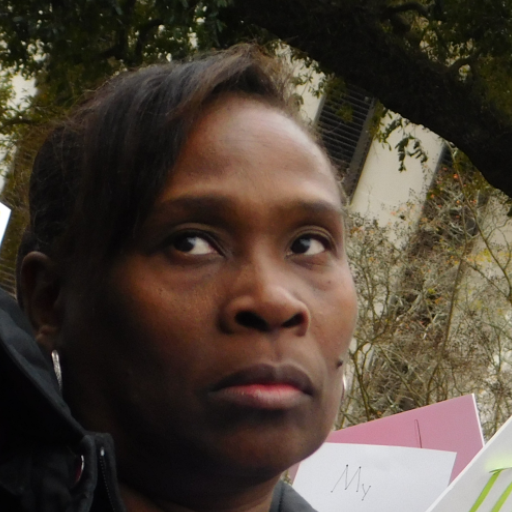

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


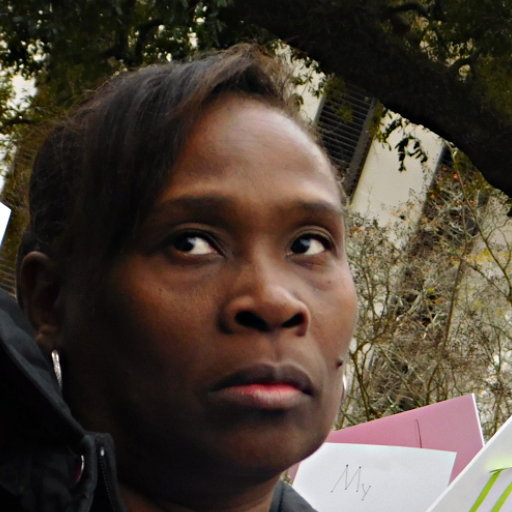

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 8
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
FILTERED IMAGE:


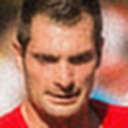

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
ORIGINAL IMAGE:


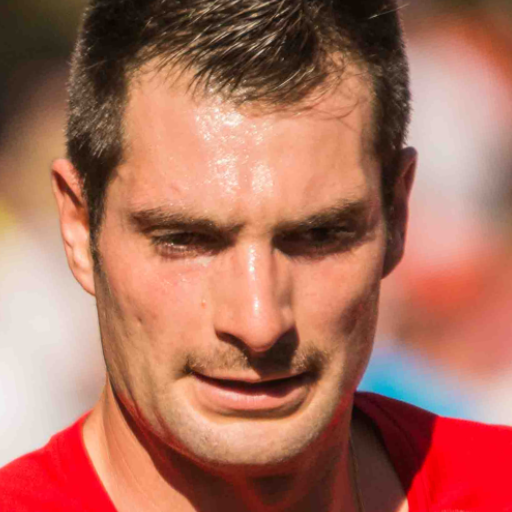

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
USM IMAGE:


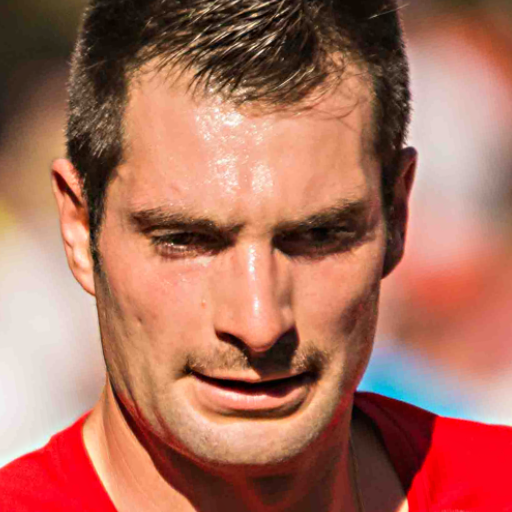

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



In [7]:
dash_line = "-".join(" " for _ in range(100))

for i, (lq_t, gt_t, gt_t_usm) in enumerate(zip(lq_batch, gt_batch, gt_usm_batch)):
    lq = tensor2PIL(lq_t)
    gt = tensor2PIL(gt_t)
    gt_usm = tensor2PIL(gt_t_usm)
    
    print(dash_line)
    print(f"Example {i+1}")
    print(dash_line)
    print("FILTERED IMAGE:")
    display(lq)
    print(dash_line)
    print("ORIGINAL IMAGE:")
    display(gt)
    print(dash_line)
    print("USM IMAGE:")
    display(gt_usm)
    print(dash_line)
    print()

# Look at Model Output

In [8]:
net = MSRResNet(
    config.MODEL.NUM_IN_CH,
    config.MODEL.NUM_OUT_CH,
    config.MODEL.NUM_FEAT,
    config.MODEL.NUM_BLOCK,
    config.MODEL.SCALE,
)
net = accelerator.prepare(net)

In [9]:
pred = net(lq_batch)

In [10]:
pred.shape

torch.Size([8, 3, 512, 512])

# Look at Wrapper Output

**Train Step**

In [11]:
optimizer = AdamW(
    net.parameters(),
    lr=config.TRAINING.ADAM_OPTIMIZER.LEARNING_RATE,
    betas=(
        config.TRAINING.ADAM_OPTIMIZER.BETA1,
        config.TRAINING.ADAM_OPTIMIZER.BETA2,
    ),
    weight_decay=config.TRAINING.ADAM_OPTIMIZER.WEIGHT_DECAY,
    eps=config.TRAINING.ADAM_OPTIMIZER.EPSILON,
)
lr_scheduler = get_scheduler(
    config.TRAINING.LR_SCHEDULER.TYPE,
    optimizer=optimizer,
    num_warmup_steps=round(
        config.TRAINING.LR_SCHEDULER.WARMUP_STEPS
        * config.ACCELERATOR.GRADIENT_ACCUMULATION_STEPS
    ),
    num_training_steps=round(
        config.TRAINING.EPOCHS
        * len(train_dataloader)
        / config.ACCELERATOR.GRADIENT_ACCUMULATION_STEPS
    ),
)

In [12]:
wrapper = RealESRNetWrapper(net, optimizer, lr_scheduler, accelerator)

In [14]:
loss, gt_pred = wrapper.train_step(lq_batch, gt_batch, gt_usm_batch)

In [15]:
loss

0.03593113273382187

In [16]:
gt_pred.shape

torch.Size([8, 3, 512, 512])